[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/notebooks/notebook_04_implementacion_arboles-published.ipynb)

## Árboles de decisión

### Metiendonos debajo del capot

En esta notebook exploraremos el funcionamiento de un árbol de decisión construido aquí mismo.

Para eso contaremos con algunas partes de código resueltas y otras que se deberán completar.

El objetivo será comprender la esencia de cómo se comportan los árboles a medida que le vamos agregando funcionalidad (o introduciendo _bugs_) para entender mejor su funcionamiento.

In [ ]:
# Puede ser necesario instalar graphviz
#!pip install graphviz

In [2]:
# Cargamos bibliotecas necesarias
import numpy as np
import pandas as pd

from collections import Counter
import operator # Trae los operadores de Python como funciones y no infix
from IPython.display import Image, display

from graphviz import Digraph
import pydotplus

A lo largo de este NoteBook usaremos objetos de distintos tipos de datos. Por simplicidad diremos que en todos los casos asumiremos que los parámetros pasados para cada función serán de los siguientes tipos:

   - el parámetro `instancias` será un `DataFrame` de `pandas`
   - el parámetro `etiquetas` será un `array` de `numpy` con valores `'Si'`, `'No'` (mismo para `etiquetas_rama_izquierda` y `etiquetas_rama_derecha`)
   - el parámetro `pregunta` será un objeto de la clase `Decision` que es definida en este mismo archivo


La clase Árbol la definiremos a continuación. Consta de:

   - un constructor
   - el método `fit` para entrenarlo (a modo de sklearn)
   - el método `predict` para dada una instancia predecir su etiqueta
   - el método `score` no se encuentra implementado aún
   - métodos para visualizar y explorar el árbol



In [3]:
# Definición de la clase árbol
from typing import Optional, Tuple


class Tree:
    def __init__(
        self,
        decision=None,  # Esto va a tener tipo Decision, una clase que vamos a definir más adelante
        left: Optional["Tree"] = None,
        right: Optional["Tree"] = None,
        labels: Optional[np.ndarray] = None,
    ):
        self.decision = decision
        self.left = left
        self.right = right

        self.data = Counter(labels) if labels is not None else None

    def fit(self, instancias: pd.DataFrame, etiquetas: np.ndarray):
        # ALGORITMO RECURSIVO para construcción de un árbol de decisión binario.

        # Suponemos que estamos parados en la raiz del árbol y tenemos que decidir cómo construirlo.
        gain, decision = encontrar_mejor_atributo_y_corte(instancias, etiquetas)

        # Criterio de corte: ¿Hay ganancia?
        if gain <= 0:
            #  Si no hay ganancia en separar, no separamos.
            self.data = Counter(etiquetas)
        else:
            # Si hay ganancia en partir el conjunto en 2
            (
                instancias_cumplen,
                etiquetas_cumplen,
                instancias_no_cumplen,
                etiquetas_no_cumplen,
            ) = partir_segun(decision, instancias, etiquetas)
            # partir devuelve instancias y etiquetas que caen en cada rama (izquierda y derecha)

            # Paso recursivo (consultar con el computadorX más cercano)
            sub_arbol_izquierdo = Tree()
            sub_arbol_izquierdo.fit(instancias_cumplen, etiquetas_cumplen)
            sub_arbol_derecho = Tree()
            sub_arbol_derecho.fit(instancias_no_cumplen, etiquetas_no_cumplen)
            # los pasos anteriores crean todo lo que necesitemos de sub-árbol izquierdo y sub-árbol derecho

            self.decision = decision
            self.left = sub_arbol_izquierdo
            self.right = sub_arbol_derecho
            self.data = Counter(etiquetas)

    def predict(self, x_t: pd.Series) -> str:
        if self.decision is None:
            if self.data["Si"] > self.data["No"]:
                return "Si"
            else:
                return "No"
        else:
            if self.decision.test(x_t):
                return self.left.predict(x_t)
            else:
                return self.right.predict(x_t)

    def score(self, X_test: pd.DataFrame, y_test: np.ndarray) -> float:
        return (X_test.apply(self.predict) == y_test).mean()

    def __repr__(self) -> str:
        return self._imprimir_arbol()

    def _imprimir_arbol(self, spacing: str = "") -> str:
        res = []
        if self.decision is None:
            res.append(spacing + f"Hoja: {dict(self.data)}")
        else:
            res.append(spacing + f"{str(self.decision)} - {dict(self.data)}")

        if self.left is not None:
            res.append(spacing + "--> True:")
            res.append(self.left._imprimir_arbol(spacing + "  "))

        if self.right is not None:
            res.append(spacing + "--> False:")
            res.append(self.right._imprimir_arbol(spacing + "  "))

        return "\n".join(res)

    def render(self) -> Digraph:
        dot = Digraph()

        self.dot_tree_aux(self, dot, prefix="")

        return dot

    def dot_tree_aux(self, subtree: "Tree", dot: Digraph, prefix: str):
        label = [
            (
                f"{subtree.decision.feature}: {subtree.decision.value}"
                if subtree.decision is not None
                else ""
            ),
            f"n={sum(subtree.data.values())}",
            str(dict(subtree.data)),
        ]
        label = "\n".join(label)
        col = "#029E3980" if subtree.data.most_common(1)[0][0] == "Si" else "#EA080080"
        dot.node(prefix + "n", label=label, shape="box", fillcolor=col, style="filled")

        if subtree.left:
            self.dot_tree_aux(subtree.left, dot, prefix + "l")
            dot.edge(prefix + "n", prefix + "ln", label="True")

        if subtree.right:
            self.dot_tree_aux(subtree.right, dot, prefix + "r")
            dot.edge(prefix + "n", prefix + "rn", label="False")

Para la decisiones en cada nodo tendremos la siguiente clase. Actualmente funciona comparando por igualdad, pero podría ser extendida en el futuro.

In [4]:
from typing import Any

class Decision:
    def __init__(self, feature: str, value: Any, test_function=operator.eq):
        self.feature = feature
        self.value = value
        self.test_function = test_function

    def test(self, x: pd.Series) -> bool:
        # Devuelve verdadero si la instancia cumple con la pregunta
        return self.test_function(self.value, x[self.feature])

    def __repr__(self):
        return "¿Es el valor para {} igual a {}?".format(self.feature, self.value)

## Funciones a completar

Primero definir la función `gini`, que dado unas etiquetas dan el grado de impureza (ver definición en la teórica), se espera que devuelva un `float`.

In [5]:
def gini(etiquetas: np.ndarray) -> float:
    # para poder usarlo mas adelante, no asumo que las etiquetas son binarias
    _, count = np.unique(etiquetas, return_counts=True)
    n = len(etiquetas)
    gini = 1 - np.sum((count / n) ** 2)
    return gini

Definir la función `ganancia_gini` que dadas ciertas instancias y una posible separación entre dos ramas nos de la mejora que obtendremos al separar de esta manera. Devuelve un `float`.

In [6]:
def ganancia_gini(etiquetas_rama_izquierda: np.ndarray, etiquetas_rama_derecha: np.ndarray) -> float:
    etiquetas = np.concatenate((etiquetas_rama_izquierda, etiquetas_rama_derecha))
    n = len(etiquetas)
    me = gini(etiquetas)
    ml = (len(etiquetas_rama_izquierda) / n) * gini(etiquetas_rama_izquierda)
    mr = (len(etiquetas_rama_derecha) / n) * gini(etiquetas_rama_derecha)
    ganancia_gini = me - ml - mr
    return ganancia_gini

Definir `partir_segun` que debe separar instancias y etiquetas según si cada instancia cumple o no con condición (ver método `test` de la clase `Decision`).

Para este punto se recomienda la utilizacion de máscaras de pandas (ver Notebook 01 - Herramientas).

Siguiendo con lo mencionado al inicio del NoteBook, la función debe devolver:

   - 2 `DataFrame` de `pandas` con las instancias que cumplen (`instancias_cumplen`) y las que no `instancias_no_cumplen`
   - 2 `array` de `numpy` con valores `'Si'`, `'No'`, uno con el valor de la etiqueta para las intancias que cumplen con la pregunta (`etiquetas_cumplen`) y otro con las etiquetas de las que no cumple (`etiquetas_cumplen`)


In [17]:
def partir_segun(
    pregunta: Decision, 
    instancias: pd.DataFrame, 
    etiquetas: np.ndarray
) -> Tuple[pd.DataFrame, np.ndarray, pd.DataFrame, np.ndarray]:
    si = pregunta.test(instancias)
    instancias_cumplen = instancias[si]
    instancias_no_cumplen = instancias[~si]
    etiquetas_cumplen = etiquetas[si]
    etiquetas_no_cumplen = etiquetas[~si]

    return instancias_cumplen, etiquetas_cumplen, instancias_no_cumplen, etiquetas_no_cumplen

A continuación se propone una implementación para poder encontrar el mejor atributo y corte posible. Esta función devuelve un `float` y una `Decision` correspondientes al mejor atributo y corte.

In [9]:
def encontrar_mejor_atributo_y_corte(
    instancias: pd.DataFrame, etiquetas: np.ndarray
) -> Tuple[float, Decision]:
    # Implementación Gini Gain.
    max_ganancia = 0
    mejor_pregunta = None
    for columna in instancias.columns:
        for valor in set(instancias[columna]):
            # Probando corte para atributo y valor
            pregunta = Decision(columna, valor)
            _, etiquetas_rama_izquierda, _, etiquetas_rama_derecha = partir_segun(
                pregunta, instancias, etiquetas
            )
            if len(etiquetas_rama_izquierda) == 0 or len(etiquetas_rama_derecha) == 0:
                continue

            ganancia = ganancia_gini(etiquetas_rama_izquierda, etiquetas_rama_derecha)

            if ganancia > max_ganancia:
                max_ganancia = ganancia
                mejor_pregunta = pregunta

    return max_ganancia, mejor_pregunta

Dado el siguiente dataset (el mismo que visto en clase):

In [10]:
X = pd.DataFrame([["Sol","Calor","Alta","Debil"],
                ["Sol","Calor","Alta","Fuerte"],
                ["Nublado","Calor","Alta","Debil"],
                ["Lluvia","Templado","Alta","Debil"],
                ["Lluvia","Frio","Normal","Debil"],
                ["Lluvia","Frio","Normal","Fuerte"],
                ["Nublado","Frio","Normal","Fuerte"],
                ["Sol","Templado","Alta","Debil"],
                ["Sol","Frio","Normal","Debil"],
                ["Lluvia","Templado","Normal","Debil"],
                ["Sol","Templado","Normal","Fuerte"],
                ["Nublado","Templado","Alta","Fuerte"],
                ["Nublado","Calor","Normal","Debil"],
                ["Lluvia","Templado","Alta","Fuerte"]],
                columns = ['Cielo', 'Temperatura', 'Humedad', 'Viento'])

y = np.array(['No', 'No', 'Si', 'Si', 'Si', 'No', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'No'])

display(X)
display(y)

,Cielo,Temperatura,Humedad,Viento
0,Sol,Calor,Alta,Debil
1,Sol,Calor,Alta,Fuerte
2,Nublado,Calor,Alta,Debil
3,Lluvia,Templado,Alta,Debil
4,Lluvia,Frio,Normal,Debil
5,Lluvia,Frio,Normal,Fuerte
6,Nublado,Frio,Normal,Fuerte
7,Sol,Templado,Alta,Debil
8,Sol,Frio,Normal,Debil
9,Lluvia,Templado,Normal,Debil


array(['No', 'No', 'Si', 'Si', 'Si', 'No', 'Si', 'No', 'Si', 'Si', 'Si',
       'Si', 'Si', 'No'], dtype='<U2')

Completar las funciones previas, entrenar y visualizar un Árbol de Decisión.

¿Es el valor para Cielo igual a Nublado? - {'No': 5, 'Si': 9}
--> True:
  Hoja: {'Si': 4}
--> False:
  ¿Es el valor para Humedad igual a Normal? - {'No': 5, 'Si': 5}
  --> True:
    ¿Es el valor para Viento igual a Fuerte? - {'Si': 4, 'No': 1}
    --> True:
      ¿Es el valor para Cielo igual a Lluvia? - {'No': 1, 'Si': 1}
      --> True:
        Hoja: {'No': 1}
      --> False:
        Hoja: {'Si': 1}
    --> False:
      Hoja: {'Si': 3}
  --> False:
    ¿Es el valor para Cielo igual a Lluvia? - {'No': 4, 'Si': 1}
    --> True:
      ¿Es el valor para Viento igual a Fuerte? - {'Si': 1, 'No': 1}
      --> True:
        Hoja: {'No': 1}
      --> False:
        Hoja: {'Si': 1}
    --> False:
      Hoja: {'No': 3}


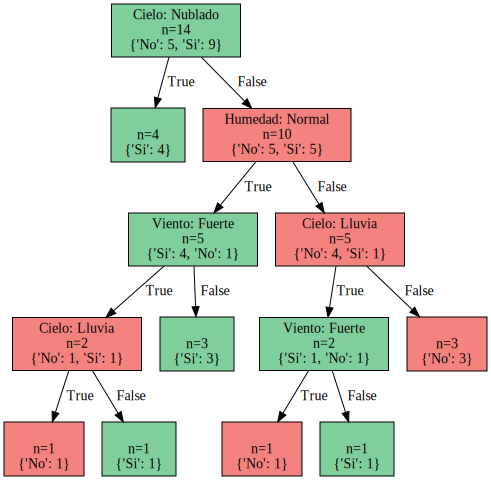

In [18]:
arbol = Tree()
arbol.fit(X, y)
print(arbol)
arbol.render()

Para evaluar instancias en el árbol podemos construirlas y evaluarlas de la siguiente manera:

In [19]:
xs_nuevo = [{'Cielo': 'Sol', 'Temperatura': 'Calor', 'Humedad': 'Alta', 'Viento': 'Debil'},
            {'Cielo': 'Nublado', 'Temperatura': 'Calor', 'Humedad': 'Alta', 'Viento': 'Debil'}]

for instancia in xs_nuevo:
    res = arbol.predict(instancia)
    print(f"Para un día {instancia} obtuve {res}")

Para un día {'Cielo': 'Sol', 'Temperatura': 'Calor', 'Humedad': 'Alta', 'Viento': 'Debil'} obtuve No
Para un día {'Cielo': 'Nublado', 'Temperatura': 'Calor', 'Humedad': 'Alta', 'Viento': 'Debil'} obtuve Si


¿Se obtuvieron los valores esperados? Explorar al menos 1 caso por cada rama del árbol.

# Opcional: Atributos continuos

La implementación anterior permite construir árboles partiendo de un dataset cuyos atributos no son continuos. Modificar dicha implementación para que soporte este tipo de atributos.
¿Qué funciones hay que modificar? 